# Tensorflow Core

## Iterative problem focused Data Science process:
- Data aquisition/scraping, cleaning, transformation. Get Data
- Exploratory Data Analysis. Get List of Hypothesis
- Model Training & Finetuning. Get Trained model
- Visualization, Storytelling. Get ok from decision makers
- Model Deployment, Real Data collection. Get Solution. Get Real Data

## Things to keep in mind:
- Occam's razor
- Computational complexity level (0)
- Data size

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import wget
import sys
import tarfile
# from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
from PIL import Image

## I. Data


### Download data
This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

Dataset credits: 
- https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/udacity
- https://classroom.udacity.com/courses/ud730

### (!) You have 2 options long and quick. 
Long option is only about 3D array construction. If you are already know how to do it - feel free to take Quick Option

In [ ]:
DATA_ROOT = '../data/commondatastorage.googleapis.com'

### Get Data: Long Option
Raw dataset comes as folders with png images, each folder contains images for a given letter. Download raw data and pickle it together as 3D archive.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

#### We current OS is Linux, and it has wget, tar, gzip installed. 
In case of any other OS - files must be downloaded and extracted manually

In [ ]:
def get_raw_archive(archive):
    url = 'http://commondatastorage.googleapis.com/books1000/{}'.format(archive)
    fpath = os.path.join(DATA_ROOT,archive)
    !wget $url -O $fpath
    !tar xzf $fpath -C $DATA_ROOT
    
get_raw_archive( "notMNIST_large.tar.gz")
get_raw_archive( "notMNIST_small.tar.gz")

In [ ]:
train_root = os.path.join(DATA_ROOT, 'notMNIST_large')
test_root = os.path.join(DATA_ROOT, 'notMNIST_small') 
train_folders = [os.path.join(train_root, d) for d in os.listdir(train_root) 
                 if not os.path.isfile(os.path.join(train_root, d))]
test_folders = [os.path.join(test_root, d) for d in os.listdir(test_root) 
                 if not os.path.isfile(os.path.join(test_root, d))]

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
### Warning: Operation can take looong time

In [ ]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
        dataset = load_letter(folder, min_num_images_per_class)
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f ) #, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

### Get Data: Quick Option
You can download prepackaged and ready for EDA 3D archives. Where x,y - normalized image data, z - image in sequence, each archive contains image samples for a given letter.

In [ ]:
def getpickle(archive, dataset):
    url = "https://s3.amazonaws.com/aihub/data/commondatastorage.googleapis.com/{}".format(archive)
    dout = os.path.join(DATA_ROOT, dataset)
    fpath = os.path.join(dout,archive)
    !wget $url -O $fpath
    !tar xzf $fpath -C $dout

getpickle( "notMNIST_large_pickle.tar.gz", "notMNIST_large" )
getpickle( "notMNIST_small_pickle.tar.gz", "notMNIST_small" )

## II. Exploratory Data Analysis - EDA

Suggested resources to learn more on EDA:
- http://datascienceguide.github.io/exploratory-data-analysis
- http://cs109.github.io/2015/index.html 

Review samples in dataset

In [ ]:
from PIL import Image
from IPython.display import Image as DisplayImage
from random import shuffle

def collage(letter, x, y):    
    path = os.path.join(DATA_ROOT, 'notMNIST_large', letter)
    files = [os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    shuffle(files)
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)    
    for idx in range(min(x*y,len(files))):
        plt.subplot(x, y, idx+1)
        img_path = os.path.join(files[idx])
        if os.path.exists(path):
            im = Image.open(img_path)
            im = im.resize((100, 100), Image.ANTIALIAS)
            plt.imshow(im,cmap='gray',vmin=0,vmax=255) 
            plt.axis('off')
    return files[0:x*y]

In [ ]:
files = collage('B',10,10)

# TODO - GROUP ALL PICKLE DATASETS TOGETHER

In [ ]:
import pickle
pixel_depth = 255.0  # Number of levels per pixel.



with open('{}/notMNIST_large/A.pickle'.format(DATA_ROOT)) as f:
    dataset_a = pickle.load(f)
with open('{}/notMNIST_large/B.pickle'.format(DATA_ROOT)) as f:
    dataset_b = pickle.load(f)

In [ ]:
def collage_pickle(letter, x, y):    
    indeces = range(0,min(1000, len(dataset)))
    shuffle(indeces)
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)    
    for idx, index in enumerate(indeces[:x*y]):
        plt.subplot(x, y, idx+1)
        plt.imshow(dataset[index] * pixel_depth + pixel_depth / 2,cmap='gray',vmin=0,vmax=255)
        plt.axis('off')

collage_pickle('A',10,10)

In [ ]:
dataset = np.concatenate((dataset_a, dataset_b), axis=0)
dataset_y = np.concatenate((np.full([len(dataset_a)], 0, dtype=np.int), np.full([len(dataset_b)], 1, dtype=np.int)), axis=0)

# TODO: PCA VISUALIZATION

In [ ]:
from sklearn.decomposition import RandomizedPCA
dataset = dataset_a + dataset_b
flat_dataset = dataset.reshape((len(dataset),28*28))
pca = RandomizedPCA(n_components=2)
X = pca.fit_transform(flat_dataset_a)


# for x, y in ...:
#     pl.scatter(x, y, c=color, label=label)
# pl.legend()
# pl.show()

# TODO: CHECK DATA IS BALANCED ACROSS CLASSES

In [ ]:
import os 

files = ['notMNIST_small/{}'.format(f) for f in os.listdir('notMNIST_small') if os.path.isfile('notMNIST_small/{}'.format(f))]
for f in files:
    with open(f) as ff:
        dataset_ = pickle.load(ff)
        print dataset_.shape, 
        print np.mean(dataset_), np.std(dataset_)
print len(files)

## Hypothesis
#### Note on hypothesis usage
*In traditional scientific process* A hypothesis is a proposed explanation for a phenomenon. For a hypothesis to be a scientific hypothesis, the scientific method requires that one can test it. Scientific method means a method of research in which a problem is identified, relevant data are gathered, a hypothesis is formulated from these data, and the hypothesis is empirically tested.

"For a hypothesis to be a business or policy hypothesis, the standards may be different. In fact, it may or may not be necessary to formulate a hypothesis for business or public policy purposes - depending on the subject matter and context..." http://www.datasciencecentral.com/profiles/blogs/to-hypothesize-or-not-to-hypothesize

#### Our Hypothesis 01: 
Linear model can get 92% accuracy on notMNIST dataset character recognition task, same as with MNIST dataset.

## Customize Dataset

### Merge / Prune / Shuffle
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.
Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
            train_letter = letter_set[vsize_per_class:end_l, :, :]
            train_dataset[start_t:end_t, :, :] = train_letter
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

# TODO RANDOMIZE & VERIFY DATA
Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [ ]:
## Save Custom Dataset

In [ ]:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

# III. Model: Logistic Regression

## Extract prepared data

In [ ]:
dataset_X = dataset_dict['train_dataset']
dataset_Y = dataset_dict['train_labels']
dataset_CVX = dataset_dict['valid_dataset']
dataset_CVY = dataset_dict['valid_labels']
dataset_TESTX = dataset_dict['test_dataset']
dataset_TESTY = dataset_dict['test_labels']
test_size = 100000
dataset_X2 = np.reshape(dataset_X[0:test_size,:,:], (test_size, dataset.shape[1]*dataset.shape[2]))
dataset_Y2 = dataset_Y[0:test_size]
dataset_TESTX2 = np.reshape(dataset_TESTX, (dataset_TESTX.shape[0], dataset.shape[1]*dataset.shape[2]))
dataset_TESTY2 = dataset_TESTY

## Fit Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

regr = linear_model.LinearRegression()
regr.fit(dataset_X2, dataset_Y2)

## Review Metrics

In [ ]:
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f" % np.mean((regr.predict(dataset_TESTX2) - dataset_TESTY2) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(dataset_TESTX2, dataset_TESTY2))


# print accuracy_score(dataset_TESTY2, regr.predict(dataset_TESTX2))

print 'SCORE:', regr.score(dataset_TESTX2, dataset_TESTY2)

# Plot outputs
plt.scatter(np.mean(dataset_TESTX2, axis=1).reshape(-1, 1), dataset_TESTY2,  color='black')
# plt.plot(dataset_TESTY2, regr.predict(dataset_TESTX2), color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## LR model conculsion: 
Hypothesis H01 doesn't hold 65% << 92%

# III. Multilayer Perceptron

H02 - shallow NN such as multilayer perceptron can get us 92%+ accuracy


## Get data

In [ ]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

In [ ]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

## Build and fit model
### Model H02.1: Multinomial Log. Reg. with Simple Gradient Descent

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [ ]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.

    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's run this computation and iterate:

In [ ]:
num_steps = 300


with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy( predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

### Model H02.2: Multinomial Log. Reg. with Stochastic Gradient Descent

Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

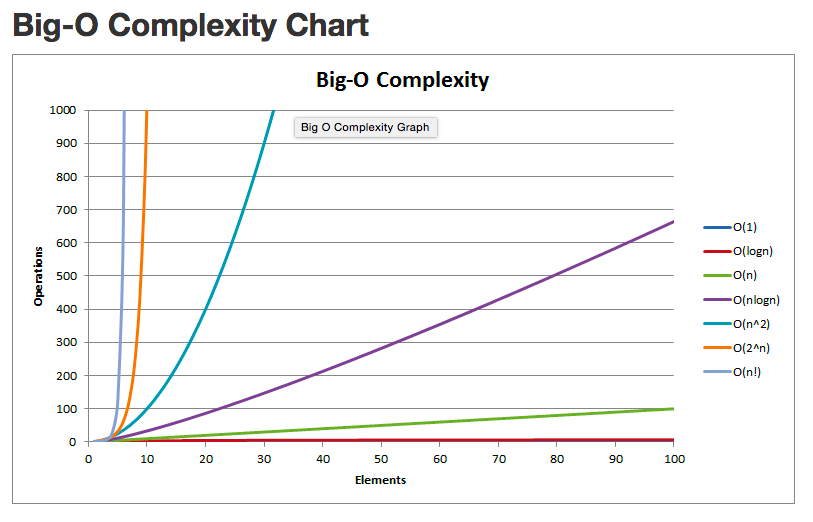

In [73]:
Image.open('comput-complexity.jpg')

In [ ]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable( tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run( [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy( valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

### Model H02.3: Multilayer Perceptron with Stochastic Gradient Descent
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. 

In [ ]:
batch_size = 128
hidden_layer_size1 = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, hidden_layer_size1]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_size1]))

    weights2 = tf.Variable( tf.truncated_normal([hidden_layer_size1, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
    relus = tf.nn.relu(logits1)
    logits2 = tf.matmul(relus, weights2) + biases2
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits2, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits2)
    
    relus_cv = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    logits_cv = tf.matmul(relus_cv, weights2) + biases2
    valid_prediction = tf.nn.softmax( logits_cv )
    
    
    relus_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1) 
    logits_test = tf.matmul(relus_test, weights2) + biases2
    test_prediction = tf.nn.softmax(logits_test)

In [ ]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run( [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy( valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

## Finetuning: Regularization

 L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

In [ ]:
batch_size = 128
hidden_layer_size1 = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, hidden_layer_size1]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_size1]))

    weights2 = tf.Variable( tf.truncated_normal([hidden_layer_size1, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
    relus = tf.nn.relu(logits1)
    logits2 = tf.matmul(relus, weights2) + biases2
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits2, tf_train_labels))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2))
    # Add the regularization term to the loss.
    loss += 5e-4 * regularizers
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits2)
    
    relus_cv = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    logits_cv = tf.matmul(relus_cv, weights2) + biases2
    valid_prediction = tf.nn.softmax( logits_cv )
    
    
    relus_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1) 
    logits_test = tf.matmul(relus_test, weights2) + biases2
    test_prediction = tf.nn.softmax(logits_test)

In [ ]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run( [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy( valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

## Finetuning. Dropout

In [ ]:
batch_size = 128
hidden_layer_size1 = 4096

SEED = None #set None for random seed

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, hidden_layer_size1]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_size1]))

    weights2 = tf.Variable( tf.truncated_normal([hidden_layer_size1, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
    relus = tf.nn.relu(logits1)
    dropout = tf.nn.dropout(relus, 0.5)
    logits2 = tf.matmul(dropout, weights2) + biases2
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits2, tf_train_labels))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2))
    
    
    
    # Add the regularization term to the loss.
    loss += 5e-4 * regularizers
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits2)
    
    relus_cv = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    logits_cv = tf.matmul(relus_cv, weights2) + biases2
    valid_prediction = tf.nn.softmax( logits_cv )
    
    
    relus_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1) 
    logits_test = tf.matmul(relus_test, weights2) + biases2
    test_prediction = tf.nn.softmax(logits_test)


In [ ]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run( [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy( valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))